## Simulation of level density analysis

Simulate a spectrum (with parameters to mimic $^{154}$Sm).

Taken from uct2018b/notebooks

1. Level spacing according to Wigner distribution.
2. Level intensity from Porter-Thomas distribution.
3. Experimental resolution of 40 keV FWHM.
4. Simulation constructed on expanded grid and then compressed into bins of 5 keV width.
5. Noise is added after the spectrum is constructed, to simulate the effect of counting statistics.
6. Only a constant spectrum.
7. Level spacing parameter is energy dependent.

8. Two methods of simulating spectrum (brute force and quick).

### Results.

1. Noise correction is applied.
2. Provided $\sigma$ is kept constant, good results are obtained for both narrow smoothing and with no narrow smoothing.
3. Even with $\sigma$ a fit parameter, results are good.
4. With $\sigma$ a fit parameter and no noise correction, results are worse.

### Conclusions.

Noise corrections are important.

***
### Index
1. [Imports](#Imports)
2. [Initialise](#Initialise)
3. [Smoothing](#Smoothing)
4. [Simulation](#Simulation)
5. [Set analysis conditions](#Set_analysis_conditions)

***
### Imports

In [1]:
import sys
sys.path.append('../../uct2018b/notebooks')
import numpy as np
import numpy.random as rnd
import spectrumtools as spt
import matplotlib.pyplot as plt
import leveldensities as ldn
import lmfit
import simlibx as sim
#import spectrumtools as spt

plt.rc('font',size=16)

***
### Initialise

In [2]:
D0=0.0001054
def De(E):
    return D0
    return D0*np.exp(-(E-10.0)/2.0)

Eres=20.0
Gamma=6.0

def E1res(e,gamma,eres):
    return e*gamma/((e**2-eres**2)**2+e**2*gamma**2)

def simulate_spectrum(Elo,Ehi,binwidth,lineshape, sigma, factor=10.0, noisy=False):
    """
    from simlib; modified
    generate a simulted spectrum in Nspect channels
    with a mean of Npk peaks.
    Each line has a shape and width determined by linehape and sigma (in channels)
    """
    Nspect=int((Ehi-Elo)/binwidth+0.5)
    w0=binwidth/10.0
    sig=sigma/w0
    g=np.zeros(Nspect*10)
    nDg=np.zeros(Nspect*10)
    print("nDG",len(nDg),Nspect)
    D0=0.0001054  # mean level spacing
    #print('** D=',D, '    rho=',1.0/D)
    e = Elo            # peak energy
    spectrum=[]
    N=0
    while e < Ehi:
        N+=1
        x=D0*sim.randomWigner()          # random level space
        y=sim.randomPT()                     # random strength
        e+=x                             # energy of level
        spectrum.append((x,y))
        ne=int((e-Elo)/w0+0.5)                    # force energy to nearest channel
        if ne<Nspect*10.0: 
            g[ne]+=y                # into spectrum
            nDg[ne]+=1.0
    # convolute with line shape
    G=sim.convolute(g, lineshape, sig)#*1000.0
    #G=sim.convolute(G,lineshape,sig*0.8)
    G=G.reshape((Nspect,10))
    G=np.sum(G,axis=1)
    nDG=nDg.reshape((Nspect,10))
    nDG=np.sum(nDG,axis=1)
    gr=g.reshape((Nspect,10))
    gr=np.sum(gr,axis=1)
    #factor=10.0
    #factor=1.0
    #Gshape=np.linspace(1.0,10.0,len(G))
    elor=np.linspace(Elo,Ehi,len(gr))
    Llo=E1res(Elo,Gamma,Eres)
    meang=np.mean(G)
    #G=G*E1res(elor,Gamma,Eres)/Llo
    if noisy:
        #meang=np.mean(G)
        #G=G*Gshape
        sigG=np.sqrt(meang)#*E1res(elor,Gamma,Eres)/Llo)
        sigG=np.sqrt(gr)#*E1res(elor,Gamma,Eres)/Llo)
        noiseG=rnd.randn(len(G))*sigG
        #print("noisy")
        #G=G+noiseG/factor
    #print(N,sig,w0,binwidth)
    #nDG=nDg
    print("nDG",len(nDG))
    return G, gr, g, noiseG, nDG, spectrum  # improve this ?

def simulate_spectrum_quick(Elo,Ehi,binwidth,lineshape, sigma, factor=10.0, noisy=False):
    """
    from simlib; modified
    generate a simulted spectrum in Nspect channels
    with a mean of Npk peaks.
    Each line has a shape and width determined by linehape and sigma (in channels)
    """
    from scipy.stats import chi2
    Nspect=int((Ehi-Elo)/binwidth+0.5)
    w0=binwidth/10.0
    sig=sigma/w0
    g=np.zeros(Nspect*10)
    levs=np.zeros(Nspect*10)
    D0=0.0001054  # mean level spacing
    #print('** D=',D, '    rho=',1.0/D)
    ND=int(w0/D0+0.5)
    ND=float(ND)
    ND=w0/D0  # 28/5/19
    varND=ND*0.273
    sigND=np.sqrt(varND)
    print("ND",ND)
    e = Elo            # peak energy
    # convolute with line shape
    for i in range(Nspect*10):
        Dbin=ND+rnd.randn()*sigND
        while Dbin <0.0:
            print('Dbin',i,Dbin)
            Dbin=ND+rnd.randn()*sigND
        sigg=np.sqrt(2.0*Dbin)
        #g[i]=(binwidth/D0)+rnd.randn()*sigg
        #g[i]=Dbin+rnd.randn()*sigg
        #Dbin=int(Dbin+0.5)  # 9/6/19
        g[i]=chi2.rvs(df=Dbin)  # was ND before 8/6/19
        levs[i]=Dbin
        if g[i] <=0.0 or g[i]>=100.0:
            print("**",i,g[i])
    G=sim.convolute(g, lineshape, sig)#*1000.0
    G=G.reshape((Nspect,10))
    G=np.sum(G,axis=1)
    gr=g.reshape((Nspect,10))
    gr=np.sum(gr,axis=1)
    levs=levs.reshape((Nspect,10))
    levs=np.sum(levs,axis=1)
    #G=sim.convolute(G,lineshape,sig*0.8)
    elor=np.linspace(Elo,Ehi,len(gr))
    Llo=E1res(Elo,Gamma,Eres)
    meang=np.mean(G)
    #G=G*E1res(elor,Gamma,Eres)/Llo
    if noisy:
        #meang=np.mean(G)
        #G=G*Gshape
        sigG=np.sqrt(meang)#*E1res(elor,Gamma,Eres)/Llo)
        sigG=np.sqrt(gr)#*E1res(elor,Gamma,Eres)/Llo)
        noiseG=rnd.randn(len(G))*sigG
        #print("noisy")
        #G=G+noiseG/factor
    #print(N,sig,w0,binwidth)
    return G, gr, g, noiseG , levs # improve this ?


In [3]:
#e=np.linspace(10.0,30.0,200)
#plt.plot(e,E1res(e,Gamma,Eres))
p="""
df=5
from scipy.stats import chi2
x = np.linspace(chi2.ppf(0.01, df),chi2.ppf(0.99, df), 100)
plt.plot(x, chi2.pdf(x, df),'r-', lw=1, alpha=0.6, label='chi2 pdf')
df=6.0
x = np.linspace(chi2.ppf(0.01, df),chi2.ppf(0.99, df), 100)
plt.plot(x, chi2.pdf(x, df),'m-', lw=1, alpha=0.6, label='chi2 pdf')
df=5.6
x = np.linspace(chi2.ppf(0.01, df),chi2.ppf(0.99, df), 100)
plt.plot(x, chi2.pdf(x, df),'g-', lw=1, alpha=0.6, label='chi2 pdf')
"""

***
### Smoothing

In [4]:
# The following parameters should probably remain fixed

# lineshape for convolutions
lineshape=sim.gauss

# set smoothing parameters in channels
smoothwide=3.5 # from 3.5
smoothnarrow=0.39*2.35

alpha=2.0+0.273            # default for N=1

esig,sig=0.0,33.0 # fwhm of experimental resolution in keV  <<<<<<<<<<<<<<<<<<<<<<<<<
print("Assumed fwhm of resolution fn is %5.1f keV"%(sig))
print(":Smooth factors: wide %5.1f; narrow %5.2f"%(smoothwide,smoothnarrow))
# convert to sdev of gaussian in MeV
sig/=1000.0   # sig in MeV
sig/=2.35      # FWHM to stdev
#print("sig",sig, sig*2.3)
# calculate smoothing widths
sigsmn=smoothnarrow*sig       # < sig   . should be 0.5*FWHM ?
sigsm=smoothwide*sig       # in MeV
sigexpt=sig
sigsm0=sigsm
sigx=sigsm*2


Assumed fwhm of resolution fn is  33.0 keV
:Smooth factors: wide   3.5; narrow  0.92


***
### Simulation

In [6]:
D=0.0001054
Dinit=D
de=0.005
# at 5 keV / channel
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800

ROIlo=ROIlo+50
ROIhi=ROIhi+50

rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV

#rnd.seed( 75096521 )

#rnd.seed( 31415 )

Noisy=True
#Noisy=False
de=0.005
rawG,hraw,rawspectrum,rawnoiseG,nDG, variates=simulate_spectrum(10.0,20.0,de,sim.gauss,
                                         sig,
                                         factor=10.0,noisy=Noisy)
variates=np.array(variates)
print(np.shape(variates))
rnd.seed( 271 )
rawG0,hraw0,rawspectrum0,rawnoiseG0,levs=simulate_spectrum_quick(10.0,20.0,de,sim.gauss,
                                         sig,
                                         factor=10.0,noisy=Noisy)
X=np.arange(0.0,2000.0,1.0)*0.005+10.0
e=X
Nspect=len(rawG)
Nlo=ROIlo
Nhi=ROIhi
Exlo,Exhi=(e[ROIlo],e[ROIhi])
print(Exlo,Exhi)

print("ROI for analysis",Nlo, Nhi, ROIlo, ROIhi)
print(len(nDG),len(rawG), 1.0/Dinit)

nDG 20000 2000
nDG 2000
(94723, 2)
ND 4.743833017077799
Dbin 3528 -0.23711638198246554
11.25 19.25
ROI for analysis 250 1850 250 1850
2000 2000 9487.666034155598


Variances 97.18164683988631 102.07492121192563


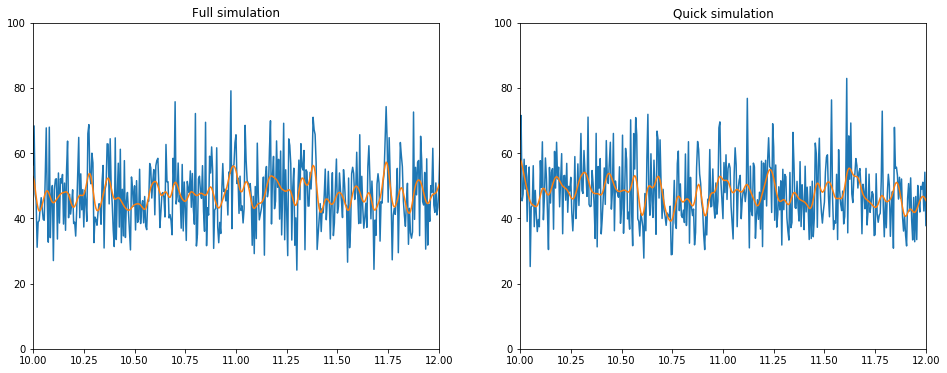

In [7]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Full simulation')
plt.plot(e,hraw)
plt.plot(e,rawG)
plt.ylim(0.0,100.0)
plt.xlim(10.0,12.0)
plt.subplot(122)
plt.title('Quick simulation')
plt.plot(e,hraw0)
plt.plot(e,rawG0)
plt.ylim(0.0,100.0)
plt.xlim(10.0,12.0)
xlo=0
xhi=int((12.0-10.0)/de+0.1)
print('Variances',np.var(hraw0[xlo:xhi]),np.var(hraw[xlo:xhi]))

(2000,)


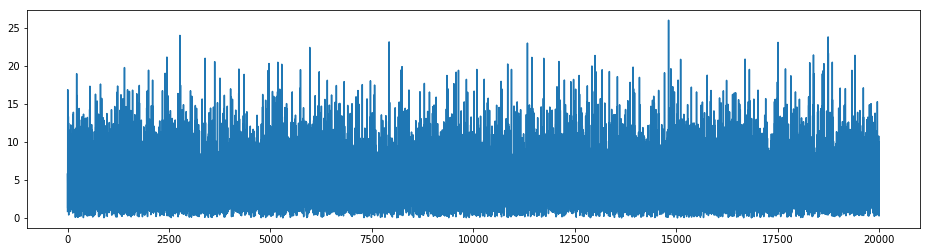

In [8]:
print(np.shape(hraw))
plt.figure(figsize=(16,4))
plt.plot(rawspectrum)

(array([1.1568e+04, 2.6752e+04, 2.7217e+04, 1.7415e+04, 8.1500e+03,
        2.7740e+03, 6.9100e+02, 1.3500e+02, 1.8000e+01, 3.0000e+00]),
 array([3.39189885e-07, 4.32211784e-05, 8.61031669e-05, 1.28985155e-04,
        1.71867144e-04, 2.14749132e-04, 2.57631121e-04, 3.00513109e-04,
        3.43395098e-04, 3.86277086e-04, 4.29159075e-04]),
 <a list of 10 Patch objects>)

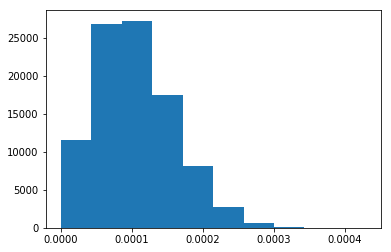

In [9]:
#plt.figure(figsize=(10,4))
#plt.plot(nDG)
#print(len(nDG),len(rawG))
#plt.figure(figsize=(10,4))
#plt.plot(levs)
plt.hist(variates.T[0])

47.36 94720.0 44.721359549995796
1.0 0.9995510954965104
10.0 9472.0 9500.4477457261 9487.666034155598


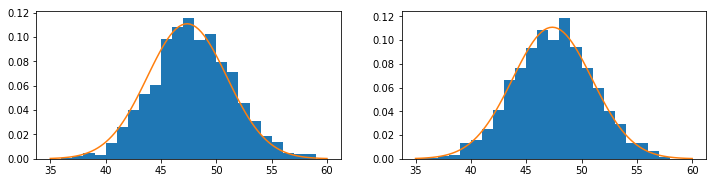

In [10]:
bins=list(range(35,60))
plt.figure(figsize=(12,6))
plt.subplot(221)
meanDG=np.mean(nDG)
totDG1=np.sum(nDG)
xDG=np.linspace(35.0,60.0,100)
#xDG=np.linspace(1.50,10.00,100)
dxDG=xDG[1]-xDG[0]
h,tmp,tmp2=plt.hist(nDG,bins=bins,density=True)
totDG=np.sqrt(len(nDG))
thDG=np.exp(-(xDG-meanDG)**2/(2.0*meanDG*0.273))/(np.sqrt(2.0*np.pi*meanDG*0.273))
plt.plot(xDG,thDG)
#plt.ylim(0.0,100.0)
#plt.xlim(10.0,12.0)
plt.subplot(222)
meanlevs=np.mean(levs)
totlevs=np.sum(levs)
#xDG=np.linspace(35.0,60.0,100)
dxDG=xDG[1]-xDG[0]
h,tmp,tmp2=plt.hist(levs,bins=bins,density=True)
#thDG=np.exp(-(xDG-meanDG)**2/(2.0*meanDG*0.273))/(np.sqrt(2.0*np.pi*meanDG*0.273))
plt.plot(xDG,thDG)
print(meanDG,totDG1,totDG)
print(np.sum(h)*(tmp[1]-tmp[0]),np.sum(thDG)*dxDG)
Ewidth=e[-1]+0.005-e[0]
print(Ewidth,totDG1/Ewidth,totlevs/Ewidth,1.0/Dinit)

(0.0, 25.0)

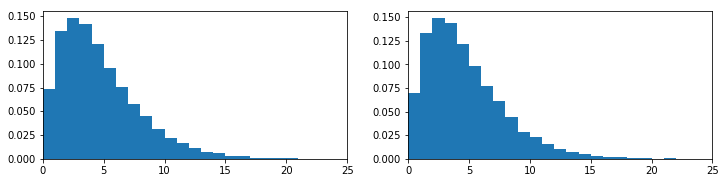

In [11]:
bins=list(range(25))
plt.figure(figsize=(12,6))
plt.subplot(221)
meansp=np.mean(rawspectrum)
xsp=np.linspace(0.0,30.0,100)
#xDG=np.linspace(1.50,10.00,100)
dxsp=xsp[1]-xsp[0]
h,tmp,tmp2=plt.hist(rawspectrum,bins=bins,density=True)
plt.xlim(0.0,25.0)#totDG=np.sqrt(len(nDG))
#thDG=np.exp(-(xDG-meanDG)**2/(2.0*meanDG*0.273))/(np.sqrt(2.0*np.pi*meanDG*0.273))
#plt.plot(xDG,thDG)
plt.subplot(222)
meansp=np.mean(rawspectrum0)
h,tmp,tmp2=plt.hist(rawspectrum0,bins=bins,density=True)
plt.xlim(0.0,25.0)

### Set analysis conditions

In [12]:
# do we use narrow smoothing as well as wide?
NarrowSmooth=True
#NarrowSmooth=False

ZapCorrection=False

# use quick simulation method
UseQuickSim = True
#UseQuickSim = False

### Analyse

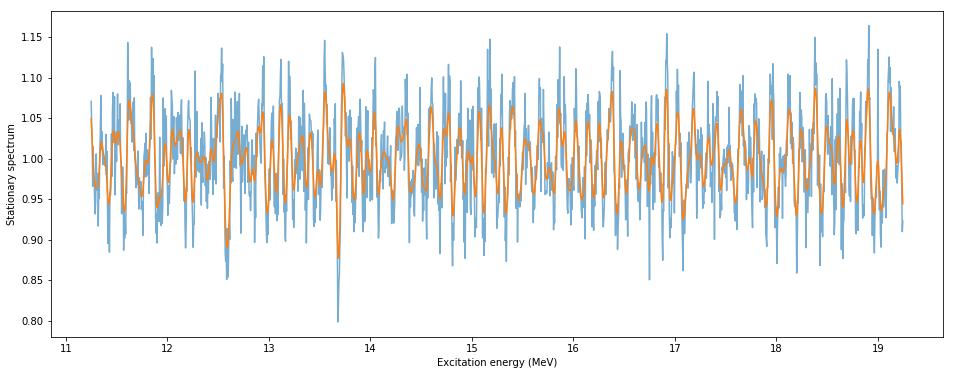

In [13]:
noisefactor=5.0
if UseQuickSim:
    G=rawG0+rawnoiseG0/noisefactor
else:
    G=rawG+rawnoiseG/noisefactor
    
S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
globalenergy = S.energy

if NarrowSmooth:
    iAC=0             # first point in autocorrelation fit
    firstoffset=0.0       # energy offset of first point
else:                 # if no narrow smooth, ignore noise in first channel
    iAC=1
    firstoffset=de

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

plt.figure(figsize=(16,6))
plt.plot(Eratio, ratioraw, alpha=0.6)
plt.plot(Eratio, rationar)
#plt.plot(Eratio,S.data[ROIlo:ROIhi])
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Stationary spectrum")
plt.show()

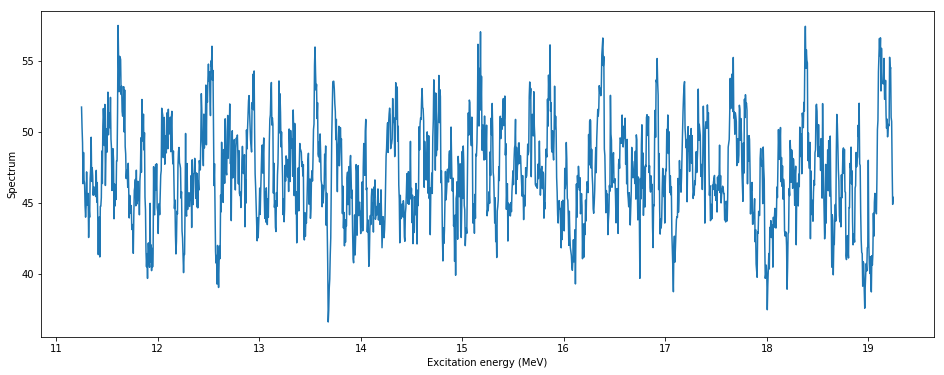

In [14]:
plt.figure(figsize=(16,6))
plt.plot(Eratio,G[ROIlo:ROIhi])
#plt.plot(Eratio,S.data[ROIlo:ROIhi])
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Spectrum")
plt.show()

### Test of variances in simulated spectra

In [15]:
# full sim      
G=rawG#+rawnoiseG/noisefactor                    # 
S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )
bins=spt.ACBinner(S,NAC=4,Nslides=2)
for l,h in bins.get_bins():
    bin=spt.Bin(bins.data,l,h)
    print(l,h,np.var(bin.dataraw))
# quick sim
G=rawG0#+rawnoiseG/noisefactor                    # 
S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )
bins=spt.ACBinner(S,NAC=4,Nslides=2)
for l,h in bins.get_bins():
    bin=spt.Bin(bins.data,l,h)
    print(l,h,np.var(bin.dataraw))


0 400 0.0026522597994537113
200 600 0.0021876148994408786
400 800 0.0020962478430411697
600 1000 0.002158399015203264
800 1200 0.0024901035595724695
1000 1400 0.002536685425948819
1200 1600 0.0028740368737930288
0 400 0.002355085083495194
200 600 0.002558361092730077
400 800 0.002538457798899076
600 1000 0.0021700863457833138
800 1200 0.002126867659037198
1000 1400 0.0022221108709318317
1200 1600 0.0024526378046881574


### Fitting

In [16]:
def fitforlm( params, e, data, unc=None ):
    """
    fit function for least sq fit using lmfit
    """
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    #sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    model*=np.exp(-e*e/(2.0*sigx**2))
    if unc is None:
        unc=np.ones(len(data))*p['initD']*0.2
    return (model-data)/unc

def model(params, e):
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    return model

In [17]:
ifig=1
Varysign=True
#UseQuickSim=True
print("NarrowSmooth ",NarrowSmooth)
print("ZapCorrection", ZapCorrection)
print("Varysig_n    ", Varysign)
print("UseQuickSim  ",UseQuickSim)
noisefactors=[10.0,5.0,3.0,2.0,1.5,1.2,1.0]
computedrho=[] # computed from AC[0]-noise, expt sign
#NarrowSmooth=True

NarrowSmooth  True
ZapCorrection False
Varysig_n     True
UseQuickSim   True


bin limits 800 1200  bin width 2.0 MeV bin contains 9450.0 9482.435795791598
data means 0.9994012711796658 0.999563843950908
initialD 0.000026 estimated from AC 0.001202
noisecorrection 1.7220945625339115e-05
[[Variables]]
    D:      9.5429e-05 +/- 1.0722e-06 (1.12%) (init = 2.631574e-05)
    sign:   0.0190481 (fixed)
    sigw:   0.05111567 (fixed)
    sigx:   0.09829787 (fixed)
    initD:  0.0001052629 (fixed)
10981.523858226843 9.106204320185006e-05 0.0011843901730536632
0.005 0.01904810227124498 0.051115665180054705 2.273 0
At 0 0.0011843901730536632 0.0011801277411088661 12.49411036859257
Computed rho 10548.981790670834  From fit 10479.010101850181
bin limits 800 1200  bin width 2.0 MeV bin contains 9450.0 9482.435795791598
data means 0.9993193720824504 0.9994932567010243
initialD 0.000027 estimated from AC 0.001249
noisecorrection 5.0526621895484664e-05
[[Variables]]
    D:      9.6191e-05 +/- 1.1199e-06 (1.16%) (init = 2.736149e-05)
    sign:   0.0190481 (fixed)
    sigw:   0.05

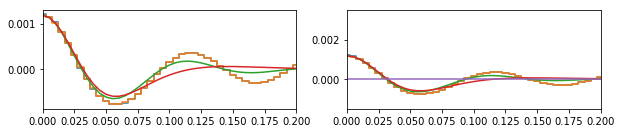

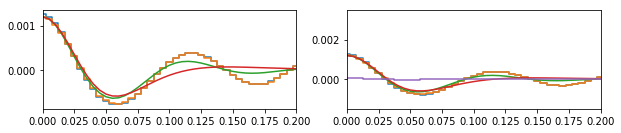

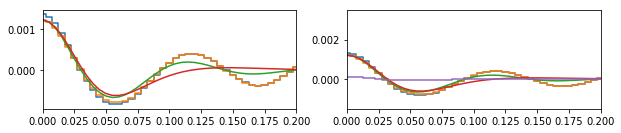

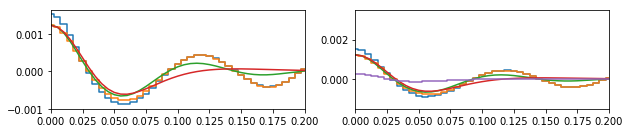

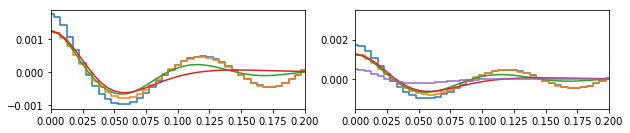

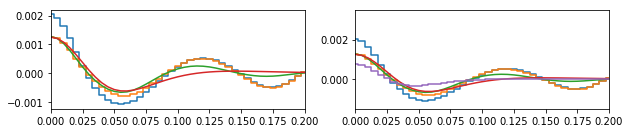

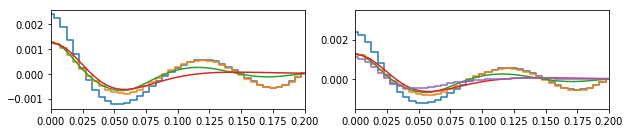

In [18]:
rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800

ROIlo=ROIlo+50
ROIhi=ROIhi+50

computedrho=[] # computed from AC[0]-noise, expt sign
evals=[]
rhovals=[]
for noisefactor in [10.0,5.0,3.0,2.0,1.5,1.2,1.0]:
#for noisefactor in [1.0]:
    if UseQuickSim:
        G=rawnoiseG0/noisefactor + rawG0               #    Note:  quick sim !
    else:
        G=rawG+rawnoiseG/noisefactor                    # 
        
    S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
    globalenergy = S.energy

    S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

    Eratio=S.Eratio
    ratioraw=S.ratioraw
    rationar=S.rationar
    bins=spt.ACBinner(S,NAC=4,Nslides=2)
    binlist=bins.get_bins()
    index=4  # choose arbitrary bin
    l,h=binlist[index]
    print("bin limits",l,h," bin width",(h-l)*0.005, "MeV", "bin contains", np.sum(nDG[l:h])/2, np.sum(levs[l:h])/2)
    bin=spt.Bin(bins.data,l,h,method=3)
    energy=bin.Eoffset
    if NarrowSmooth:
        data=bin.acnar
    else:
        data=bin.acraw
    print("data means",np.mean(bin.dataraw), np.mean(bin.datanar))
    # increase sig to account for convolution of g
    sigw=np.sqrt(sig**2+sigsm**2)
    sign=sig
    if NarrowSmooth:
        sign=np.sqrt(sig**2+sigsmn**2)
        sigaim=sig
    ys=sigw/sign
    alpha=2.273
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    print("initialD %8.6f estimated from AC %8.6f"%(initialD,data[0]))
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sign,min=0.0, vary=False)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    params.add('initD',value=initialD*4,vary=False)
    noise=bin.get_noise_correction2(sigsmn, sigsm, NarrowSmooth)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
    print("noisecorrection",noise[0])
    #ACfx=data*np.exp(-energy**2/(2.0*sigx**2))
    #initial=1.0
    #popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
    #sig=popt[1]
    #popt[0]*=initialD
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx))
                           #fcn_kws={'unc'=uncert})
    result=minner.minimize()
    m=model(result.params, energy)
    lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    Ntypes = 1 
    signf=p['sign']
    sigwf=p['sigw']
    D=ACfx[0]/spt.ACtheory(de,signf,sigwf,alpha,1.0)*Ntypes
    D=ACfx[1]/spt.ACtheory(de,sign,sigw,alpha,1.0)*Ntypes
    ##D=data[1]/spt.ACtheory(de,sign,sigw,alpha,1.0)*Ntypes

    DD=p["D"]*Ntypes
    rhoD=1.0/DD
    rho=1.0/D
    print(rho, D, ACfx[iAC])
    truemodel=spt.ACtheory(energy,sign,sigw,alpha,Dinit)*Ntypes
    m=spt.ACtheory(energy,sign,sigw,alpha,D)*Ntypes
    plt.figure(figsize=(10,4))
    plt.subplot(221)
    plt.plot(energy, data, drawstyle='steps-mid')
    plt.plot(energy, data-noise, drawstyle='steps-mid')
    plt.plot(energy,ACfx)
    plt.plot(energy, m)
    plt.xlim(0.0,energy[-1]/4)
    plt.xlim(0.0,0.2)
    plt.subplot(222)
    plt.plot(energy, data, drawstyle='steps-mid')
    plt.plot(energy, data-noise, drawstyle='steps-mid')
    plt.plot(energy,ACfx)
    plt.plot(energy, m)
    
    plt.plot(energy, noise, drawstyle='steps-mid')
    plt.ylim(-0.0015,0.0035)
    plt.xlim(0.0,0.2)
    """ 
    plt.plot(bin.spectrumraw)
    """
    print(de,p['sign'],sigw,alpha,iAC )
    print("At 0", ACfx[iAC], m[0], spt.ACtheory(de,p['sign'],sigw,alpha,1.0))
    print("Computed rho",1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)),' From fit',rhoD)
    computedrho.append(1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))
    #computedrho.append(1.0/(m[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))

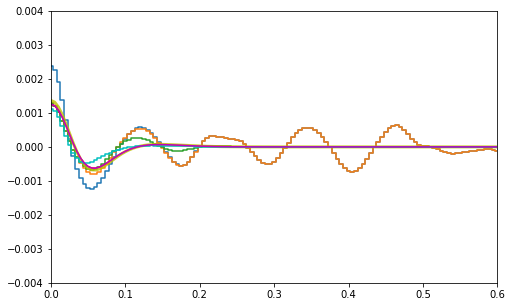

9.711494428987777e-05 9.70043467030494e-05 0.01904810227124498 0.01904810227124498 0.051115665180054705 0.051115665180054705


In [19]:
# replot of last
plt.figure(figsize=(8,5))
plt.plot(energy, data, drawstyle='steps-mid')
plt.plot(energy, data-noise, drawstyle='steps-mid')
plt.plot(energy,ACfx, drawstyle='steps-mid')
m=spt.ACtheory(energy, sign, sigw, alpha, D)
plt.plot(energy, m, 'r-')
plt.plot(energy,truemodel, 'y-', lw=3, alpha=0.8)
mdl=model(result.params,energy)
plt.plot(energy, noise, 'c-', drawstyle='steps-mid')
plt.plot(energy,mdl,'m-')
plt.xlim(0.0,energy[-1]/4)
plt.xlim(0.0,0.6)
plt.ylim(-0.004,0.004)
plt.show()
p=result.params
print(p['D'].value,D,p['sign'].value,sign,p['sigw'].value,sigw)

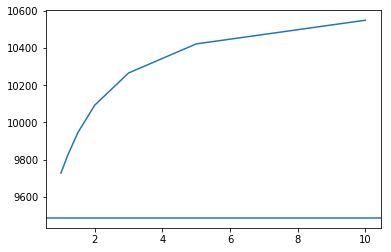

In [20]:
plt.plot(noisefactors,computedrho)
plt.axhline(1.0/Dinit)

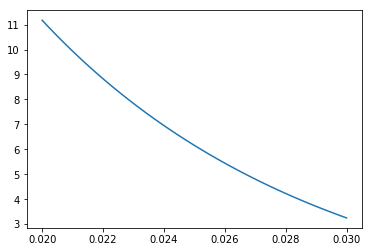

In [21]:
sn=np.linspace(0.020,0.030,50)
hf=spt.ACtheory(de,sn,sigw,alpha,1.0)
plt.plot(sn,hf)

0 400 11.25 13.245000000000001
initialD 0.000029 estimated from AC 0.001343
noisecorrection 0.0001398877535025342
[[Variables]]
    D:      9.1391e-05 +/- 7.3305e-06 (8.02%) (init = 2.942275e-05)
    sign:   0.0190481 (fixed)
    sigw:   0.05111567 (fixed)
    sigx:   0.09829787 (fixed)
    initD:  0.000117691 (fixed)
10606.2471755845
0.005 0.01904810227124498 0.051115665180054705 2.273 0
At 0 0.0012035937447405034 0.0011843881615498679 12.49411036859257
Computed rho 10380.670739765534
200 600 12.25 14.245000000000001
initialD 0.000032 estimated from AC 0.001458
noisecorrection 0.00014235002364351905
[[Variables]]
    D:      9.7990e-05 +/- 7.1556e-06 (7.30%) (init = 3.192752e-05)
    sign:   0.0190481 (fixed)
    sigw:   0.05111567 (fixed)
    sigx:   0.09829787 (fixed)
    initD:  0.0001277101 (fixed)
9688.829893923
0.005 0.01904810227124498 0.051115665180054705 2.273 0
At 0 0.0013155024758327563 0.0012699146486103942 12.49411036859257
Computed rho 9497.59548014791
400 800 13.25 15.2

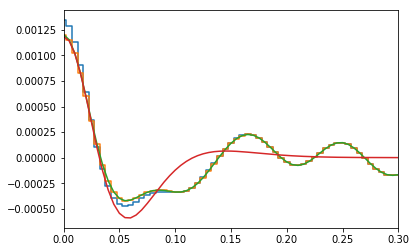

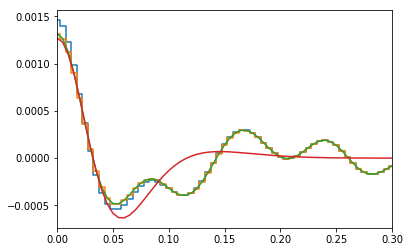

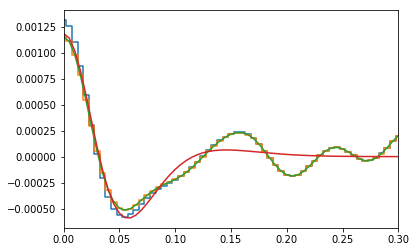

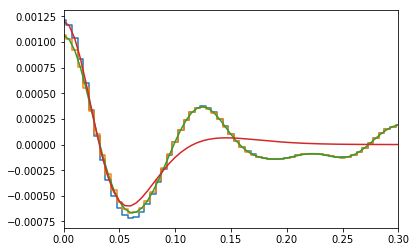

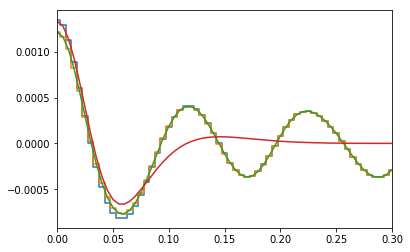

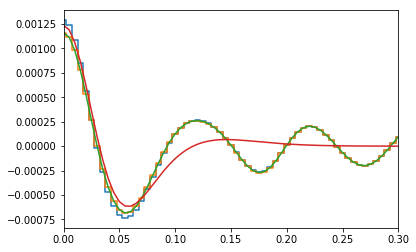

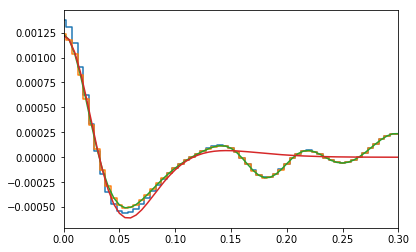

In [22]:
NarrowSmooth=True
computedrho=[] # computed from AC[0]-noise, expt sign

noisefactor=3.0
if UseQuickSim:
    G=rawG0+rawnoiseG0/noisefactor
else:
    G=rawG#+rawnoiseG/noisefactor

S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
globalenergy = S.energy

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

bins=spt.ACBinner(S,NAC=4,Nslides=2)
#print("Computed bin limits:\n",bins.get_bins())
binlist=bins.get_bins()

evals=[]
rhovals=[]
for b in bins.get_bins():
    l,h=b
    print(l,h,Eratio[l],Eratio[h-1])
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    data=bin.acnar
    # calculate alpha from M1 fraction assuming N1=N2
    # first get mean m1 fraction

    # increase sig to account for convolution of g
    sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
    sign=sig
    if NarrowSmooth:
        sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
        sigaim=sig
    ys=sigw/sign
    alpha=2.273
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    print("initialD %8.6f estimated from AC %8.6f"%(initialD,data[0]))
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sign,min=0.0, vary=False)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    params.add('initD',value=initialD*4,vary=False)
    noise=bin.get_noise_correction2(sigsmn, sigsm, NarrowSmooth)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)######*np.exp(-energy**2/(2.0*sigx**2))
    print("noisecorrection",noise[0])
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx))
                           #fcn_kws={'unc'=uncert})
    result=minner.minimize()
    m=model(result.params, energy)
    lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    Ntypes = 1 
    signf=p['sign']
    sigwf=p['sigw']
    D=(ACfx[0]+ACfx[1])/2/spt.ACtheory(de,signf,sigwf,alpha,1.0)*Ntypes
    #m=spt.ACtheory(energy,signf,sigwf,alpha,D)*Ntypes
    #D=p["D"]*Ntypes
    rho=1.0/D
    print(rho)
    rhovals.append(rho)
    evals.append((Eratio[h-1]+Eratio[l])/2)
    
    plt.figure()
    plt.plot(energy, data, drawstyle='steps-mid')
    plt.plot(energy, data-noise, drawstyle='steps-mid')
    plt.plot(energy,ACfx)
    plt.plot(energy, m)
    plt.xlim(0.0,energy[-1]/4)
    plt.xlim(0.0,0.3)
    """ 
    plt.plot(bin.spectrumraw)
    """
    print(de,p['sign'],sigw,alpha,iAC )
    print("At 0", ACfx[0], m[0], spt.ACtheory(de,p['sign'],sigw,alpha,1.0))
    print("Computed rho",1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))
    computedrho.append(1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))

9487.666034155598 9487.666034155598 9487.666034155598


(5000, 2000000)

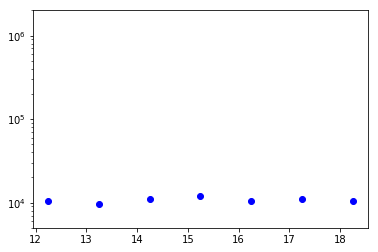

In [23]:
print(1.0/D0,1.0/De(10.0),1.0/De(12.0))
plt.figure()
erho=np.linspace(12.0,18.0,100)
rho=1.0/De(erho)
plt.semilogy(evals,rhovals,'bo')
#plt.semilogy(erho,rho,'r-')
plt.ylim(5000,2000000)

In [32]:
computedrho=[] # computed from AC[0]-noise, expt sign
noisefactor=3.0
sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
sign=sig
if NarrowSmooth:
    sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
    sigaim=sig
ys=sigw/sign
alpha=2.273

rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV

for i in range(200):
    rawG,hraw,rawspectrum,rawnoiseG=simulate_spectrum(10.0,20.0,0.005,sim.gauss,
                                         sig,
                                         factor=10.0,noisy=Noisy)
    G=rawG+rawnoiseG/noisefactor
    S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
    globalenergy = S.energy

    S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )


    bins=spt.ACBinner(S,NAC=4,Nslides=2)
    #print("Computed bin limits:\n",bins.get_bins())
    binlist=bins.get_bins()

    for b in bins.get_bins():
        l,h=b
        #print(l,h)
        bin=spt.Bin(bins.data,l,h)
        energy=bin.Eoffset
        data=bin.acnar
        noise=bin.get_noise_correction(sigsmn, sigsm)
        uncert=np.linspace(data[0]/10,data[0]/5,ndata)
        ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
        D=ACfx[0]/spt.ACtheory(de,sign,sigw,alpha,1.0)#*Ntypes
        rho=1.0/D
        computedrho.append(rho)
print("DONE")

DONE


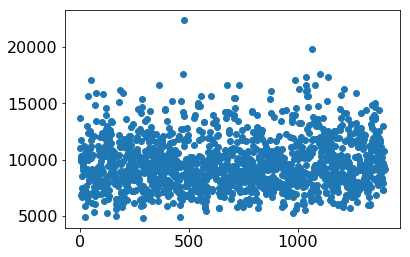

In [52]:
plt.plot(computedrho,'o')

Text(0,0.5,'Probability density')

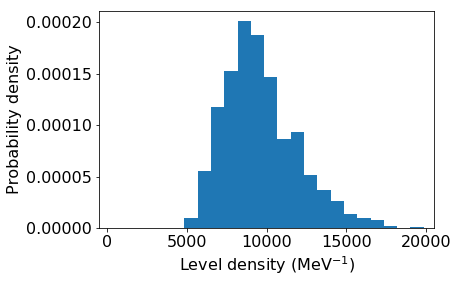

In [61]:
crho=np.array(computedrho)
plt.hist(crho,bins=21,density=True)
plt.xlim(-500,20500)
plt.xlabel(r"Level density (MeV$^{-1}$)")
plt.ylabel(r"Probability density")

In [62]:
print(np.mean(crho), np.sqrt(np.var(crho/np.mean(crho))))

9641.412281977095 0.24039490667941615


In [63]:
print(np.mean(crho)/np.sqrt(np.var(crho)), 0.81/2.37)

4.159821910593021 0.34177215189873417
